# House Price prediction with AutoML (Accelerated Data Science Python SDK)

In [1]:
# Load a number of libraries, including the Accelerated Data Science DatasetFactory and initialize it.
import pandas as pd
import logging
import numpy as np
import ads
import oci
from oci.data_science import DataScienceClient
from ads.dataset.factory import DatasetFactory

# OCI ADS API
ads.set_auth(auth='resource_principal')
resource_principal = oci.auth.signers.get_resource_principals_signer()
dsc = DataScienceClient(config={},signer=resource_principal)

In [2]:
# Load the House Price data set using the ADS library. 
# This library is capable of loading data from a variety of sources, including OCI Object Storage, 
# Autonomous Database (ADW and ATP), other Oracle databases, Hadoop, S3, and many more. 
# In this case the file is simply loaded from the block storage of the OCI Data Science service 
# itself.

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
ds = DatasetFactory.open("housesales.csv", target="SalePrice")

In [3]:
# Automatic Data Preparation with ADS:
# Last time we investigated every feature to decide whether it needed to be included in the model 
# training. We manually had to check for things like number of unique values and missing values.
# Instead of doing this manually, let's ask ADS for suggestions on what changes to make to the
# data set.
# The following will show a summary of the recommendations. For example, ADS can recommend how 
# to handle missing values. And it will recommend what to do with columsn that appear identifiers.
# Note that this can take up to a minute (depending on the shape you've chosen).

suggestion_df = ds.suggest_recommendations()

HTML(value='<li>detected wide dataset (81 columns)</li>')

HTML(value='<li>feature reduction using mutual information (max 16 columns)</li>')

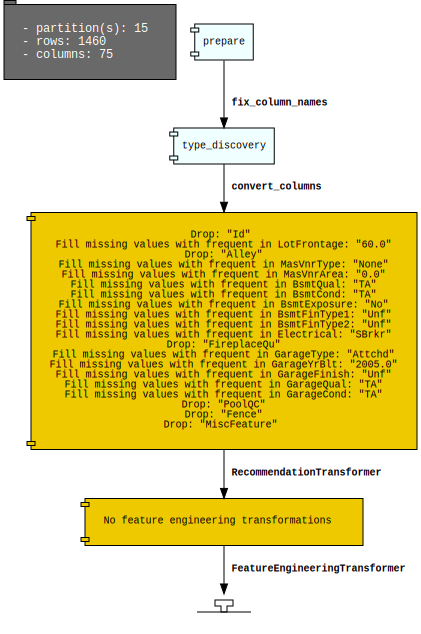

In [4]:
# Imagine that we decide to simply take the recommendations made by ADS. Before we run the 
# transformations, let's have a look at the original situation.
# For example, ADS suggests that we drop the columns Id, Alley, FireplaceQu, et ceters.
# ADS also suggests that we set default values for missing values in LotFrontage, MasVnrArea, 
# et cetera.
# Now, let's apply the recommended transformations.
# We will also visualize the transformations.

ds_transformed = ds.auto_transform()
ds_transformed.visualize_transforms()

In [5]:
# Let's visualize the end result.
# We see that there are now only 74 features left.

ds_transformed.summary()

,Feature,Datatype
0,SalePrice,ordinal/int32
1,MSSubClass,ordinal/int16
2,MSZoning,categorical/category
3,LotFrontage,ordinal/float64
4,LotArea,ordinal/int32
...,...,...
70,MiscVal,ordinal/int16
71,MoSold,categorical/category
72,YrSold,ordinal/int16
73,SaleType,categorical/category


In [6]:
# AutoML:
# Now let's move on to building the model.
# We will run an experiment in which we create 3 models:
# 1: Linear Regression manually configured
# 2: Ridge Regression manually configured
# 3: AutoML
# Once we've trained the models, we will compare their performance.
#

# Preparation:
# 1. Resolve the skew in the target SalePrice by doing a log operation.
ds_transformed = ds_transformed.assign_column('SalePrice', lambda x: np.log(x))

# 2. Convert categorical attributes to numeric attributes
from ads.dataset.label_encoder import DataFrameLabelEncoder
ds_encoded = DataFrameLabelEncoder().fit_transform(ds_transformed.to_pandas_dataframe())

# 3. Separate the dataset in target and input features and split into test and train.
y = ds_encoded['SalePrice']
X = ds_encoded.drop(['SalePrice'], axis=1)
ds_done = DatasetFactory.open(ds_encoded, target="SalePrice")
train, test = ds_done.train_test_split(test_size=0.2)

In [7]:
# First train two models manually (without AutoML): Linear Regression and Ridge Regression.
# We'll use these later to compare their performance against the model created by AutoML.

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from ads.common.model import ADSModel
X = train.X.copy()
y = train.y.copy()
lr = LinearRegression()
rr = Ridge(alpha=13.5)
lr_model_fit = lr.fit(X, y)
rr_model_fit = rr.fit(X, y)
lr_model = ADSModel.from_estimator(lr_model_fit, name="LinearRegression")
rr_model = ADSModel.from_estimator(rr_model_fit, name="Ridge")


In [8]:
# Now, let's see how well AutoML can perform the same task.
# AutoML will evaluate several algorithms in combination with different values for their 
# hyperparameters.
# Note the time parameter of 160 seconds, this means we allow AutoML this amount of time to find the best solution.

from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
ml_engine = OracleAutoMLProvider(n_jobs = -1) # n_jobs = -1 means that we are not going to limit the resources and let the AutoML to do this for us and take as much as possible
automl = AutoML(train, provider=ml_engine)
model, baseline = automl.train(time_budget=160, random_state=42)


In [9]:
# Have a look at the top candidate that was selected by AutoML. What algorithm is it? 
# What are the hyperparameters it's using?
#
# Now, let's compare the performance of the manual and AutoML models

from ads.evaluations.evaluator import ADSEvaluator
evaluator = ADSEvaluator(test, models=[model, baseline, lr_model, rr_model], training_data=train)
evaluator.metrics


HTML(value='<style  type="text/css" >\n    #T_72d2d906_6de8_11ec_bd59_0242ac130002  {\n          text-align: r…

HTML(value='<style  type="text/css" >\n    #T_72d88928_6de8_11ec_bd59_0242ac130002  {\n          text-align: r…

In [10]:
# Conclusion:
# The models have been compared using various metrics.
# The best performing metrics are displayed in green.
#
# For example, look at the Mean Square Error, this is a measure of how close the predicted values
# match the actual values. The value of the AutoML model is significantly lower than that of the 
# manually configured models, meaning that the AutoML model is performing better.
# The same is the case for the other metrics.
#